In [ ]:
# 30-day readmission prediction model using logistic regression
# =======================================================================
# Goal: Predict the likelihood of a patient being readmitted within 30 days after discharge.
# Output: A logistic regression model that outputs the probability of readmission.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
# Load the dataset
df = pd.read_csv(r'C:\Users\darry\Data Analysis ML Project Portfolio\Readmission Rate Proj 2\Data\diabetic_data.csv')
print(df.shape)
df.head()

(101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [8]:
# Standardize column name format
df.columns = [c.strip().lower().replace(' ', '_').replace('-', '') for c in df.columns]
df.columns


    

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburidemetformin',
       'glipizidemetformin', 'glimepiridepioglitazone',
       'metforminrosiglitazone', 'metforminpioglitazone', 'change',
       'diabetesmed', 'readmitted'],
      dtype='object')

In [11]:
df['readmitted'].value_counts(dropna=False)

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [12]:
# Define Outcome Target: 'readmitted within 30 days' (Yes/No)
df['readmitted_30'] = (df['readmitted'] == '<30').astype(int)

# Baseline readmission rate
baseline_readmission_rate = df['readmitted_30'].mean()
print(f'Baseline 30-day readmission rate:', baseline_readmission_rate)

Baseline 30-day readmission rate: 0.11159915885462728


In [15]:
# Data cleaning
df = df.replace('?', np.nan)

drop_cols = [c for c in ['encounter_id', 'patient_nbr', 'readmitted', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3'] if c in df.columns]

# Define independent variables and target variable
X = df.drop(columns=drop_cols + ['readmitted_30'])
y = df['readmitted_30']

print('X shape:', X.shape)
print('Y mean (baseline readmission rate):', y.mean())

X shape: (101766, 41)
Y mean (baseline readmission rate): 0.11159915885462728


In [ ]:
#  Numeric and Categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
# Use X (not X_train) because we haven't split yet
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print('categorical_cols:', len(categorical_cols))
print('numeric_cols:', len(numeric_cols))

categorical_cols: 11
numeric_cols: 30


In [40]:
# Create preprocessing pipelines for both numeric and categorical data
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),
    ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
])

# Build the Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [42]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (81412, 41)
Test: (20354, 41)


In [51]:
# Train the Model
model.fit(X_train, y_train)

# Predict and Probabilities
predictions = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the Model
print('Roc AUC', roc_auc_score(y_test, predicted_proba))
print(classification_report(y_test, predictions))


Roc AUC 0.6453525262067057
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.50      0.01      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.69      0.51      0.48     20354
weighted avg       0.85      0.89      0.84     20354



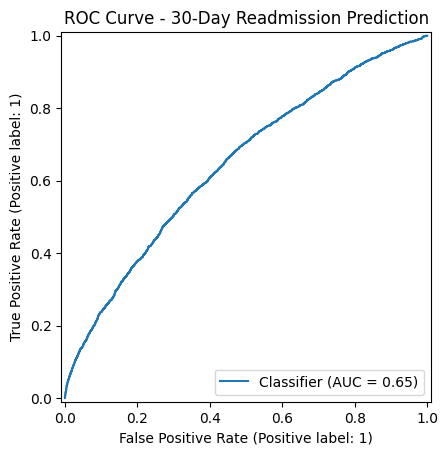

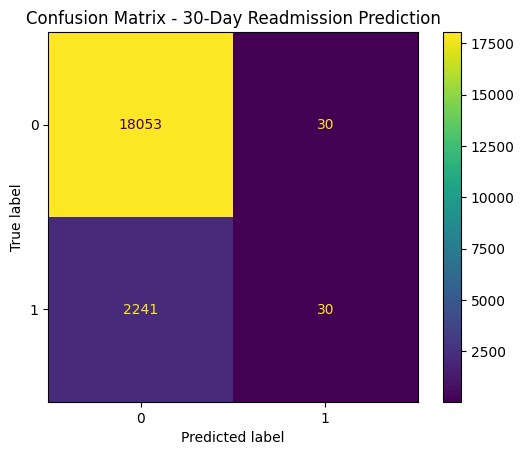

In [46]:
# Data Visualization: ROC Curve and Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay


RocCurveDisplay.from_predictions(y_test, predicted_probs)
plt.title('ROC Curve - 30-Day Readmission Prediction')
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.title('Confusion Matrix - 30-Day Readmission Prediction')
plt.show()

In [52]:
# Risk Stratification
results = X_test.copy()
results['risk'] = predicted_proba
results['actual_readmission'] = y_test.values

threshold = results['risk'].quantile(0.90)

high_risk = results[results['risk'] >= threshold]
low_risk = results[results['risk'] < threshold]

print("Baseline:", y_test.mean())
print('Top 10% Risk Readmission Rate:', high_risk['actual_readmission'].mean())
print('Bottom 90% Risk Readmission Rate:', low_risk['actual_readmission'].mean())
print('risk threshold for top 10%:', threshold)


Baseline: 0.11157512036946055
Top 10% Risk Readmission Rate: 0.2362475442043222
Bottom 90% Risk Readmission Rate: 0.09771809149470466
risk threshold for top 10%: 0.16442513644734727
